In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df_train=pd.read_csv("train.csv")
df_train.head()

,sample_id,catalog_content,image_link,price
0,33127,"Item Name: La Victoria Green Taco Sauce Mild, ...",https://m.media-amazon.com/images/I/51mo8htwTH...,4.89
1,198967,"Item Name: Salerno Cookies, The Original Butte...",https://m.media-amazon.com/images/I/71YtriIHAA...,13.12
2,261251,"Item Name: Bear Creek Hearty Soup Bowl, Creamy...",https://m.media-amazon.com/images/I/51+PFEe-w-...,1.97
3,55858,Item Name: Judee’s Blue Cheese Powder 11.25 oz...,https://m.media-amazon.com/images/I/41mu0HAToD...,30.34
4,292686,"Item Name: kedem Sherry Cooking Wine, 12.7 Oun...",https://m.media-amazon.com/images/I/41sA037+Qv...,66.49


In [4]:
df_train.describe()

,sample_id,price
count,75000.000000,75000.000000
mean,149841.917707,23.647654
std,86585.346513,33.376932
min,0.000000,0.130000
25%,73845.750000,6.795000
50%,150129.000000,14.000000
75%,225040.250000,28.625000
max,299438.000000,2796.000000


--- 1. Basic Data Inspection ---
Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sample_id        75000 non-null  int64  
 1   catalog_content  75000 non-null  object 
 2   image_link       75000 non-null  object 
 3   price            75000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.3+ MB

Descriptive Statistics for 'price':
count    75000.000000
mean        23.647654
std         33.376932
min          0.130000
25%          6.795000
50%         14.000000
75%         28.625000
max       2796.000000
Name: price, dtype: float64

--- 2. Analyzing the Target Variable: 'price' ---


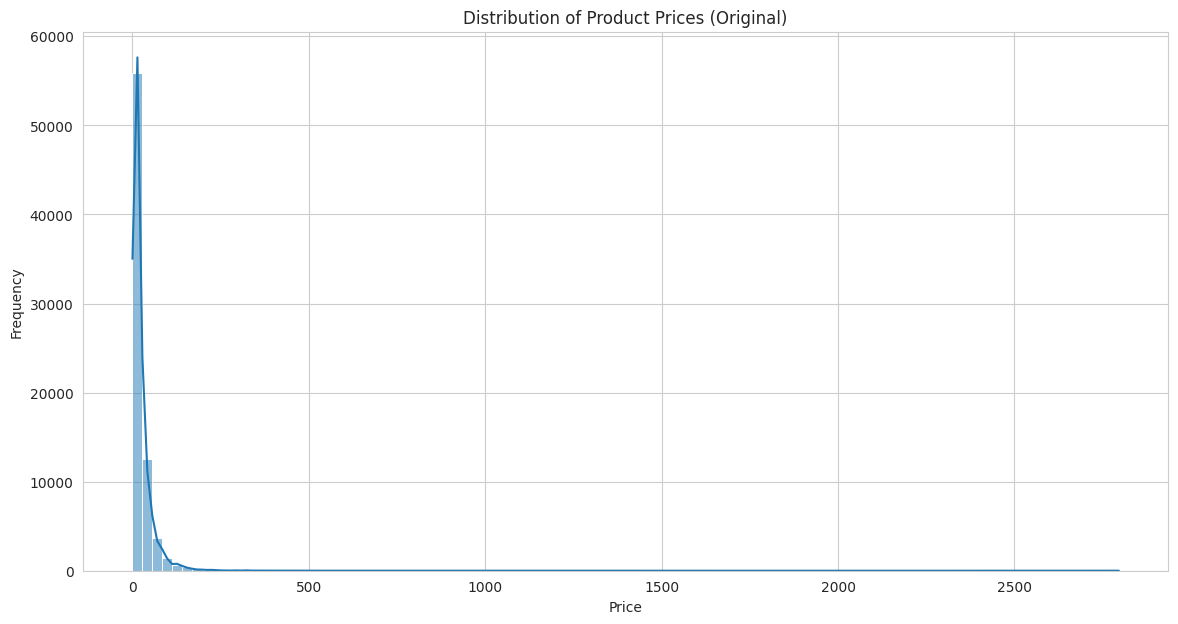

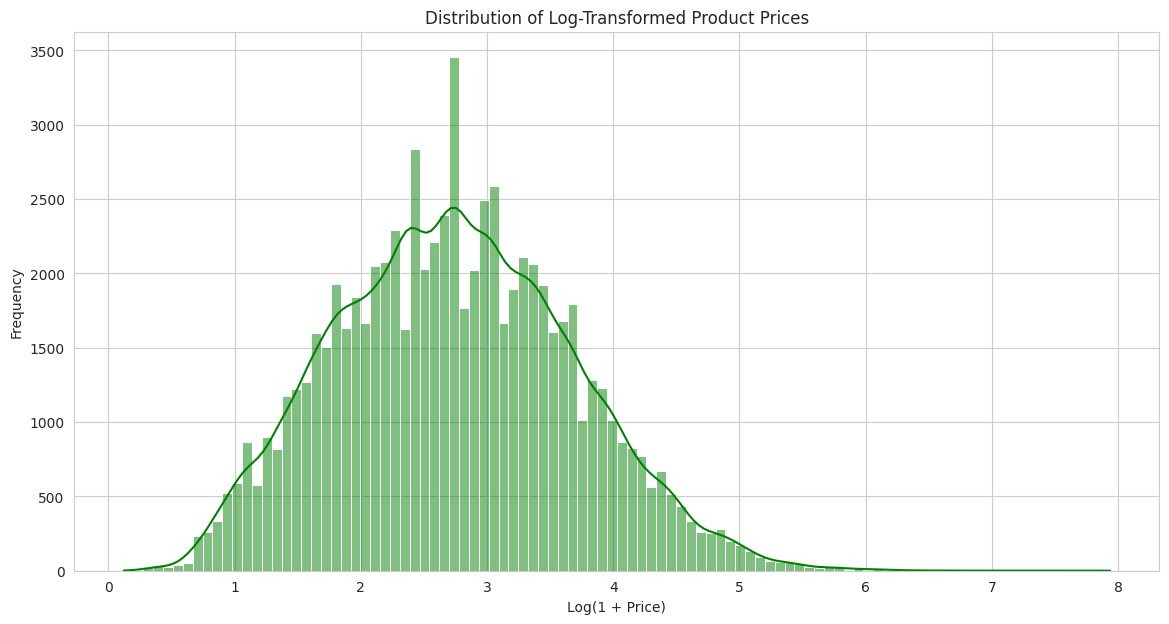


--- 3. Analyzing the 'catalog_content' (Text Data) ---


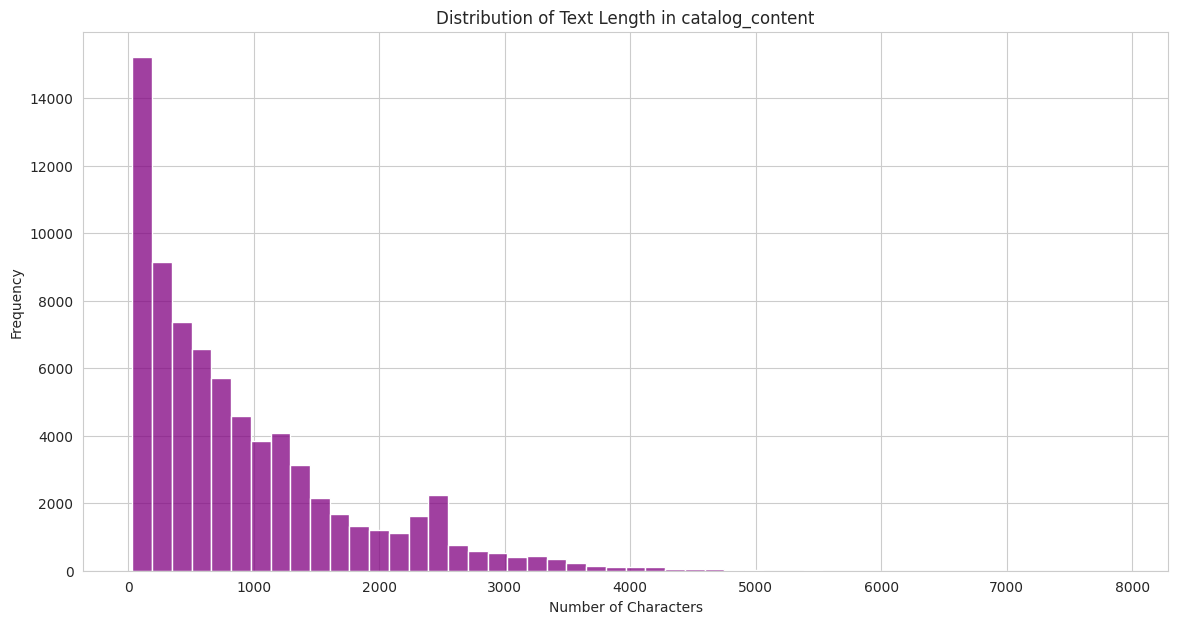


Displaying a few full 'catalog_content' samples:

--- SAMPLE 1 ---
Item Name: La Victoria Green Taco Sauce Mild, 12 Ounce (Pack of 6)
Value: 72.0
Unit: Fl Oz


--- SAMPLE 2 ---
Item Name: Salerno Cookies, The Original Butter Cookies, 8 Ounce (Pack of 4)
Bullet Point 1: Original Butter Cookies: Classic butter cookies made with real butter
Bullet Point 2: Variety Pack: Includes 4 boxes with 32 cookies total
Bullet Point 3: Occasion Perfect: Delicious cookies for birthdays, weddings, anniversaries
Bullet Point 4: Shareable Treats: Fun to give and enjoy with friends and family
Bullet Point 5: Salerno Brand: Trusted brand of delicious butter cookies since 1925
Value: 32.0
Unit: Ounce


--- SAMPLE 3 ---
Item Name: Bear Creek Hearty Soup Bowl, Creamy Chicken with Rice, 1.9 Ounce (Pack of 6)
Bullet Point 1: Loaded with hearty long grain wild rice and vegetables
Bullet Point 2: Full of hearty goodness
Bullet Point 3: Single serve bowls
Bullet Point 4: Easy to prepare mix
Bullet Point 5: 0 gram

In [5]:
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 7)

print("--- 1. Basic Data Inspection ---")
# Get a summary of data types and check for missing values
print("Dataset Information:")
df_train.info()

# Get descriptive statistics for the 'price' column
print("\nDescriptive Statistics for 'price':")
print(df_train['price'].describe())
# PAY ATTENTION HERE: Compare the 'mean' with the '50%' (median).
# A mean that is much larger than the median is a strong indicator of right-skewness.

#-------------------------------------------------------------------------------

print("\n--- 2. Analyzing the Target Variable: 'price' ---")

# Plot a histogram to see the distribution of prices
plt.figure()
sns.histplot(df_train['price'], bins=100, kde=True)
plt.title('Distribution of Product Prices (Original)')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()
# YOU WILL SEE: A graph heavily concentrated on the left with a long tail to the right.

# Because of the skew, let's apply a log transformation to normalize it.
# We use np.log1p which calculates log(1 + x) to handle potential zero values gracefully.
df_train['log_price'] = np.log1p(df_train['price'])

# Now, let's plot the distribution of the log-transformed price
plt.figure()
sns.histplot(df_train['log_price'], bins=100, kde=True, color='green')
plt.title('Distribution of Log-Transformed Product Prices')
plt.xlabel('Log(1 + Price)')
plt.ylabel('Frequency')
plt.show()
# YOU WILL SEE: This distribution looks much more like a "bell curve", which is ideal for training ML models.

#-------------------------------------------------------------------------------

print("\n--- 3. Analyzing the 'catalog_content' (Text Data) ---")

# Let's get a sense of the length of the product descriptions
df_train['text_length'] = df_train['catalog_content'].str.len()

plt.figure()
sns.histplot(df_train['text_length'], bins=50, color='purple')
plt.title('Distribution of Text Length in catalog_content')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.show()
# This tells us about the variation in the amount of text detail we have for each product.

# Let's print out a few full examples to see the content structure
print("\nDisplaying a few full 'catalog_content' samples:")
for i in range(3):
  print(f"\n--- SAMPLE {i+1} ---")
  print(df_train['catalog_content'].iloc[i])
# LOOK FOR: Brand names, product details, and especially quantity info like "Pack of", "Count", "oz", "IPQ", etc.

#-------------------------------------------------------------------------------

print("\n\n--- EDA Summary ---")
print("""
1. The dataset is clean with no missing values in the primary columns.
2. The target variable 'price' is highly right-skewed.
3. We have successfully created a new target 'log_price' which is normally distributed and much better for model training.
4. The 'catalog_content' is rich with information that we will need to extract in the next step.
""")

In [6]:
import re # Import the regular expressions library
from tqdm import tqdm # A library to show progress bars

# It's good practice to make a copy to work on, preserving the original
df_processed = df_train.copy()

def extract_ipq(text):
    """
    Extracts the Item Pack Quantity (IPQ) from a product's catalog content.
    Uses a series of regular expression patterns to find quantity information.
    Defaults to 1 if no quantity is found.
    """
    # Convert text to lowercase to make matching case-insensitive
    text = str(text).lower()

    # List of regex patterns to find IPQ. We look for a number (\d+)
    # associated with keywords like 'pack', 'count', 'set', 'ipq:', etc.
    patterns = [
        r'pack of (\d+)',    # e.g., "pack of 12"
        r'(\d+)\s*pack',      # e.g., "12 pack"
        r'(\d+)\s*count',     # e.g., "12 count"
        r'set of (\d+)',     # e.g., "set of 4"
        r'case of (\d+)',    # e.g., "case of 24"
        r'box of (\d+)',     # e.g., "box of 50"
        r'ipq\s*:\s*(\d+)',   # e.g., "IPQ: 6" or "ipq:6"
        r'(\d+)\s*pcs',       # e.g., "100pcs"
        r'(\d+)\s*pieces'    # e.g., "100 pieces"
    ]

    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            # If a pattern matches, the number is in the first "capturing group"
            # We convert it to an integer and return it.
            return int(match.group(1))

    # If the loop finishes and no pattern was found, we assume the IPQ is 1.
    return 1

# --- Apply the function to our DataFrame ---

# The tqdm library wraps around our operation to show a nice progress bar,
# which is helpful for long-running processes.
print("Extracting IPQ from 'catalog_content'. This might take a moment...")
tqdm.pandas()
df_processed['ipq'] = df_processed['catalog_content'].progress_apply(extract_ipq)

print("\nIPQ extraction complete.")

# --- Verify the Results ---

print("\n--- Value Counts of Extracted IPQ (Top 15) ---")
print(df_processed['ipq'].value_counts().head(15))

print("\n--- Examples where IPQ > 1 was extracted ---")
# Display content and the IPQ we extracted to see if it worked correctly
print(df_processed[df_processed['ipq'] > 1][['catalog_content', 'ipq']].head(10))

Extracting IPQ from 'catalog_content'. This might take a moment...


100%|██████████| 75000/75000 [00:06<00:00, 11624.59it/s]


IPQ extraction complete.

--- Value Counts of Extracted IPQ (Top 15) ---
ipq
1      44809
6       5492
12      5232
2       4396
3       3765
4       2313
24      1447
8       1224
10       780
5        529
20       455
18       365
16       284
100      253
40       239
Name: count, dtype: int64

--- Examples where IPQ > 1 was extracted ---
                                      catalog_content  ipq
0   Item Name: La Victoria Green Taco Sauce Mild, ...    6
1   Item Name: Salerno Cookies, The Original Butte...    4
2   Item Name: Bear Creek Hearty Soup Bowl, Creamy...    6
6   Item Name: Goya Foods Sazonador Total Seasonin...    6
9   Item Name: Mrs. Miller's Seedless Black Raspbe...    4
11  Item Name: Albanese Assorted Gummi Bears, Suga...    2
12  Item Name: KiZE Bars, 4 Count, Cookie Dough Fl...    4
13  Item Name: Smuckers Natural Peanut Butter Chun...   12
14  Item Name: BODYARMOR LYTE Sports Drink Low-Cal...   12
16  Item Name: Himalania Pink Salt Fine Jar 10.0 O...    6


In [7]:
# Before splitting the data, add this line:
print(f"Original shape of df_processed: {df_processed.shape}")
df_processed.dropna(subset=['price'], inplace=True)
print(f"Shape of df_processed after dropping NaNs: {df_processed.shape}")

# Now, continue with your script:
# X = df_processed[['catalog_content', 'ipq']]
# y = df_processed['log_price']
# ... etc

Original shape of df_processed: (75000, 7)
Shape of df_processed after dropping NaNs: (75000, 7)


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

# --- Define our SMAPE evaluation function ---
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# --- 1. Define Features (X) and Target (y) ---
# Our features are the text content and the ipq. Our target is the log_price.
X = df_processed[['catalog_content', 'ipq']]
y = df_processed['log_price']

# --- 2. Split Data into Training and Validation Sets ---
# 80% for training, 20% for validation. random_state ensures we get the same split every time.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# --- 3. Create a Preprocessing Pipeline for our Features ---

# This preprocessor will apply different steps to different columns.
# It's the modern, correct way to handle mixed data types in scikit-learn.
preprocessor = ColumnTransformer(
    transformers=[
        # Transformer 1: For the 'catalog_content' column
        ('text', TfidfVectorizer(stop_words='english', max_features=15000), 'catalog_content'),

        # Transformer 2: For the 'ipq' column
        ('numeric', StandardScaler(), ['ipq'])
    ],
    remainder='passthrough' # Keep other columns if any (none in this case)
)

# --- 4. Create the Full Model Pipeline ---
# This pipeline first runs our preprocessor, then feeds the result into our Ridge regression model.
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0)) # alpha is a regularization parameter
])

# --- 5. Train the Model ---
print("\nTraining the baseline model...")
pipeline.fit(X_train, y_train)
print("Training complete.")

# --- 6. Make Predictions and Evaluate ---
print("\nMaking predictions on the validation set...")
# The model predicts in log scale
predictions_log = pipeline.predict(X_val)

# IMPORTANT: We must convert both predictions and true values back to the original price scale before calculating SMAPE.
predictions_actual = np.expm1(predictions_log)
y_val_actual = np.expm1(y_val)

# Ensure no negative predictions, as price must be positive
predictions_actual[predictions_actual < 0] = 0

# Calculate the SMAPE score
validation_smape = smape(y_val_actual, predictions_actual)

print("\n--- EVALUATION RESULTS ---")
print(f"SMAPE on Validation Set: {validation_smape:.4f}%")

Training data shape: (60000, 2)
Validation data shape: (15000, 2)

Training the baseline model...
Training complete.

Making predictions on the validation set...

--- EVALUATION RESULTS ---
SMAPE on Validation Set: 56.4668%


In [9]:
import os
import requests
from PIL import Image
from io import BytesIO
from tqdm import tqdm

# --- 1. Create Directories to Store Images ---
# We'll create a main 'images' folder with subfolders for train and test images
if not os.path.exists('dataset/images'):
    os.makedirs('dataset/images/train')
    os.makedirs('dataset/images/test')
    print("Created directories: 'dataset/images/train/' and 'dataset/images/test/'")

TRAIN_IMAGE_DIR = 'dataset/images/train/'

# --- 2. Define the Image Downloading Function ---
def download_image(sample_id, url, save_dir):
    """
    Downloads an image from a URL and saves it.
    Skips if the file already exists. Handles download errors.
    """
    filepath = os.path.join(save_dir, f"{sample_id}.jpg")

    # Don't re-download if it already exists
    if os.path.exists(filepath):
        return 'exists'

    try:
        # Make a request to the URL, with a timeout to prevent it from hanging forever
        response = requests.get(url, timeout=10)
        # Raise an error if the download failed (e.g., 404 Not Found)
        response.raise_for_status()

        # Open the image from the downloaded content
        img = Image.open(BytesIO(response.content))

        # Convert to RGB if it's not (e.g., palette-based PNGs) to ensure consistency
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Save the image as a JPEG
        img.save(filepath, 'JPEG')
        return 'success'

    except Exception as e:
        # If anything goes wrong (timeout, bad URL, etc.), just record it and move on
        return 'failed'

# --- 3. Run the Download Process on a SAMPLE of the data ---
# Let's start with the first 1000 images to test our code.
# Once this works, you can change this number or run it on the whole dataframe.
SAMPLE_SIZE = 10000
df_sample = df_processed.head(SAMPLE_SIZE)

print(f"\nStarting to download the first {SAMPLE_SIZE} training images...")

# Use tqdm to track progress
status_counts = {'success': 0, 'exists': 0, 'failed': 0}
for index, row in tqdm(df_sample.iterrows(), total=len(df_sample)):
    status = download_image(row['sample_id'], row['image_link'], TRAIN_IMAGE_DIR)
    status_counts[status] += 1

print("\n--- Download Complete ---")
print(f"Successfully downloaded: {status_counts['success']}")
print(f"Already existed: {status_counts['exists']}")
print(f"Failed to download: {status_counts['failed']}")

Created directories: 'dataset/images/train/' and 'dataset/images/test/'

Starting to download the first 10000 training images...


100%|██████████| 10000/10000 [14:14<00:00, 11.70it/s]


--- Download Complete ---
Successfully downloaded: 10000
Already existed: 0
Failed to download: 0


In [10]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import os
from tqdm import tqdm
import numpy as np

# --- 1. Set up the Model and Transformations ---

# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# "Chop off" the last layer (the classifier). We want the features before it.
# We access the model's children and take all but the last one.
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])

# Put the model in evaluation mode (important for consistency)
feature_extractor.eval()
# Move the model to the selected device (GPU or CPU)
feature_extractor.to(device)

# Define the standard transformations for ImageNet models
# 1. Resize the image to 256x256
# 2. Crop the center 224x224 part
# 3. Convert the image to a PyTorch Tensor
# 4. Normalize the tensor with the standard ImageNet mean and std deviation
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# --- 2. Function to Get Embedding for a Single Image ---

def get_image_embedding(image_path, model, device):
    """Takes an image path, preprocesses it, and returns its feature vector."""
    try:
        img = Image.open(image_path).convert('RGB')
        # Apply the transformations and add a "batch" dimension (required by the model)
        img_t = preprocess(img).unsqueeze(0)

        # Move the tensor to the GPU/CPU
        img_t = img_t.to(device)

        # Tell PyTorch not to calculate gradients (saves memory and computation)
        with torch.no_grad():
            # Get the features
            features = model(img_t)
            # Flatten the features from a 4D tensor to a 1D vector
            embedding = features.squeeze().cpu().numpy()
        return embedding
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        # Return a vector of zeros if an image is corrupted or fails
        return np.zeros(2048) # ResNet50's feature vector size is 2048

# --- 3. Process All Downloaded Sample Images ---

# Get the list of image files we downloaded
image_files = [f for f in os.listdir(TRAIN_IMAGE_DIR) if f.endswith('.jpg')]
# We only want to process the sample we downloaded
sample_ids = df_sample['sample_id'].tolist()
sample_image_files = [f"{sid}.jpg" for sid in sample_ids if f"{sid}.jpg" in image_files]

print(f"\nFound {len(sample_image_files)} images to process from our sample.")

image_embeddings = {} # Dictionary to store {sample_id: embedding_vector}

# Loop through the image files with a progress bar
for filename in tqdm(sample_image_files, desc="Extracting image features"):
    sample_id = int(os.path.splitext(filename)[0]) # Get sample_id from '12345.jpg'
    filepath = os.path.join(TRAIN_IMAGE_DIR, filename)

    embedding = get_image_embedding(filepath, feature_extractor, device)
    image_embeddings[sample_id] = embedding

print("\n--- Feature Extraction Complete ---")
print(f"Successfully created embeddings for {len(image_embeddings)} images.")
print(f"Each embedding is a vector of size: {next(iter(image_embeddings.values())).shape}")

# --- 4. Save the Embeddings for Later Use ---
# We'll save this as a numpy file, which is efficient
np.save('sample_image_embeddings.npy', image_embeddings)
print("\nSaved the embeddings dictionary to 'sample_image_embeddings.npy'")

Using device: cuda


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 190MB/s]



Found 10000 images to process from our sample.


Extracting image features: 100%|██████████| 10000/10000 [06:36<00:00, 25.23it/s]



--- Feature Extraction Complete ---
Successfully created embeddings for 10000 images.
Each embedding is a vector of size: (2048,)

Saved the embeddings dictionary to 'sample_image_embeddings.npy'


In [12]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Define our SMAPE evaluation function again ---
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# --- 1. Load and Prepare the Combined Data ---

# Load the saved embeddings dictionary
image_embeddings = np.load('sample_image_embeddings.npy', allow_pickle=True).item()

# Convert the embeddings dictionary into a DataFrame
# The keys (sample_id) will be the index
# Each element of the 2048-vector will be a column
embedding_df = pd.DataFrame.from_dict(image_embeddings, orient='index',
                                    columns=[f'img_feat_{i}' for i in range(2048)])
embedding_df['sample_id'] = embedding_df.index

# Get the original sample data (first 1000 rows)
SAMPLE_SIZE = 10000
df_sample = df_processed.head(SAMPLE_SIZE)

# Merge the original data with the new image features
df_multimodal = pd.merge(df_sample, embedding_df, on='sample_id')

print("Successfully merged text, IPQ, and image features.")
print(f"Shape of our new multimodal DataFrame: {df_multimodal.shape}")

# --- 2. Build the Multimodal Model Pipeline ---

# Define our features (X) and target (y) from the new multimodal dataframe
X = df_multimodal.drop(columns=['price', 'log_price', 'image_link', 'sample_id'])
y = df_multimodal['log_price']

# Split the data using the SAME random_state to ensure a fair comparison with the baseline
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Get the list of our image feature column names
image_feature_cols = [f'img_feat_{i}' for i in range(2048)]

# Create a new preprocessor. We need to tell it what to do with the new image features.
# Since they are already processed numbers, we can just 'passthrough'.
preprocessor_multimodal = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', max_features=1000), 'catalog_content'),
        ('numeric', StandardScaler(), ['ipq'])
    ],
    remainder='passthrough' # This tells the pipeline to keep the image feature columns as they are
)

# Create the new pipeline with LightGBM as the regressor
pipeline_multimodal = Pipeline(steps=[
    ('preprocessor', preprocessor_multimodal),
    ('regressor', lgb.LGBMRegressor(random_state=42))
])

# --- 3. Train and Evaluate the Expert Model ---
print("\nTraining the multimodal expert model...")
pipeline_multimodal.fit(X_train, y_train)
print("Training complete.")

print("\nMaking predictions with the expert model...")
predictions_log = pipeline_multimodal.predict(X_val)
predictions_actual = np.expm1(predictions_log)
y_val_actual = np.expm1(y_val)

predictions_actual[predictions_actual < 0] = 0

validation_smape = smape(y_val_actual, predictions_actual)

print("\n--- EXPERT MODEL EVALUATION ---")
print(f"SMAPE on Validation Set: {validation_smape:.4f}%")
print(f"Baseline Model SMAPE (for comparison): 56.4944%")

improvement = 56.4944 - validation_smape
print(f"\nImprovement over baseline: {improvement:.4f}%")

Successfully merged text, IPQ, and image features.
Shape of our new multimodal DataFrame: (10000, 2055)

Training the multimodal expert model...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.666427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 611516
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 3050
[LightGBM] [Info] Start training from score 2.738906
Training complete.

Making predictions with the expert model...

--- EXPERT MODEL EVALUATION ---
SMAPE on Validation Set: 59.6524%
Baseline Model SMAPE (for comparison): 56.4944%

Improvement over baseline: -3.1580%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [13]:
from collections import Counter

# We will look at the first 3 words of the 'Item Name:' part of the content
# and count their occurrences.
word_counts = Counter()
# Let's use the full 75k dataset for this analysis to be accurate
# Assuming you have a clean df_processed from the previous step
for content in tqdm(df_processed['catalog_content']):
    # Extract text after "Item Name:" and take the first few words
    try:
        item_name = content.split('Item Name:')[1].split(',')[0]
        words = item_name.strip().split()[:3]
        for word in words:
            word_counts[word] += 1
    except:
        continue

print("--- Most Common Words (Potential Brands) ---")
print(word_counts.most_common(30))

100%|██████████| 75000/75000 [00:01<00:00, 66176.34it/s]

--- Most Common Words (Potential Brands) ---
[('Organic', 4056), ('Tea', 2289), ('-', 2153), ('Coffee', 1819), ('&', 1325), ('Chocolate', 1323), ('Food', 1196), ('Foods', 1133), ('Original', 1080), ('to', 1021), ('Black', 995), ('Live', 960), ('Gourmet', 929), ('Red', 895), ('of', 834), ('White', 830), ('The', 794), ('Candy', 758), ('Sugar', 746), ('Natural', 690), ('Premium', 670), ('Green', 668), ('Sweet', 642), ('Spice', 638), ('McCormick', 630), ('Fruit', 609), ('Free', 603), ('Milk', 583), ('Hot', 545), ('Sauce', 520)]


In [14]:
# Based on analysis, let's define a list of top brands
# You can add or remove from this list based on the output of the code above
TOP_BRANDS = [
    'goya', 'kraft', 'mccormick', 'bragg', 'nature', 'valley', 'annies', 'ghirardelli',
    'barilla', 'post', 'quaker', 'kind', 'starbucks', 'walkers', 'frito-lay', 'lays',
    'tostitos', 'cheetos', 'doritos', 'kelloggs', 'general', 'mills', 'betty', 'crocker',
    'progresso', 'campbells', 'swanson', 'v8', 'prego', 'pace', 'raos', 'newmans', 'own',
    'hidden', 'bulls-eye', 'a.1.', 'heinz', 'frenchs', 'hellmanns', 'best', 'foods',
    'colgate', 'crest', 'oral-b', 'sensodyne', 'doves', 'axe', 'suave', 'tresemme',
    'tide', 'gain', 'downy', 'bounty', 'charmin', 'scott', 'kleenex', 'clorox', 'lysol'
]

def extract_brand(text):
    text_lower = text.lower()
    for brand in TOP_BRANDS:
        if brand in text_lower:
            return brand
    return 'Other'

# IMPORTANT: We are adding this new feature to our 10k sample DataFrame
df_multimodal['brand'] = df_multimodal['catalog_content'].apply(extract_brand)
print("\n'brand' feature created. Value counts:")
print(df_multimodal['brand'].value_counts())

# --- NOW WE REBUILD AND RETRAIN THE MODEL WITH THE NEW FEATURE ---
from sklearn.preprocessing import OneHotEncoder

# Our features now include 'brand'
X = df_multimodal.drop(columns=['price', 'log_price', 'image_link', 'sample_id'])
y = df_multimodal['log_price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# We need to add a step for our new categorical 'brand' feature: OneHotEncoder
preprocessor_final = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', max_features=10000), 'catalog_content'),
        ('numeric', StandardScaler(), ['ipq']),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), ['brand']) # New step!
    ],
    remainder='passthrough' # For the image features
)

pipeline_final = Pipeline(steps=[
    ('preprocessor', preprocessor_final),
    ('regressor', lgb.LGBMRegressor(random_state=42))
])

print("\nTraining the FINAL model with text, IPQ, images, AND brand...")
pipeline_final.fit(X_train, y_train)
print("Training complete.")

# --- Final Evaluation ---
predictions_log = pipeline_final.predict(X_val)
predictions_actual = np.expm1(predictions_log)
y_val_actual = np.expm1(y_val)
predictions_actual[predictions_actual < 0] = 0
validation_smape = smape(y_val_actual, predictions_actual)

print("\n--- FINAL MODEL EVALUATION ---")
print(f"SMAPE on Validation Set: {validation_smape:.4f}%")
print(f"Baseline Model SMAPE: 56.4944%")
improvement = 56.4944 - validation_smape
print(f"\nImprovement over baseline: {improvement:.4f}%")


'brand' feature created. Value counts:
brand
Other          6348
own            1353
best            477
nature          426
foods           284
kind            154
gain            117
post            113
mccormick        80
starbucks        57
valley           55
goya             55
general          54
kraft            53
betty            51
pace             45
mills            43
quaker           22
charmin          20
lays             19
ghirardelli      16
heinz            15
progresso        14
barilla          14
doritos          12
walkers          11
swanson          10
v8                9
hidden            9
axe               8
cheetos           7
prego             6
bragg             5
annies            4
colgate           4
tostitos          4
scott             4
crest             3
newmans           3
tide              3
raos              2
kelloggs          2
frito-lay         2
bounty            1
doves             1
campbells         1
a.1.              1
oral-b        

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# --- We need to define SMAPE as a scorer for GridSearchCV ---
# GridSearchCV needs a scorer where higher is better, so we'll have it minimize the error.
def smape_loss(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Add a small epsilon to the denominator to avoid division by zero
    return np.mean(numerator / (denominator + 1e-6))

# We need to convert log-scale predictions back to actual scale inside the scorer
def smape_scorer_func(y_true_log, y_pred_log):
    y_true_actual = np.expm1(y_true_log)
    y_pred_actual = np.expm1(y_pred_log)
    return smape(y_true_actual, y_pred_actual)

# Create the scorer object for GridSearchCV. We set greater_is_better=False because a lower SMAPE is better.
smape_scorer = make_scorer(smape_scorer_func, greater_is_better=False)


# --- Define the Grid of Parameters to Search ---
# We are telling GridSearchCV to try these different settings for the 'regressor' step in our pipeline.
param_grid = {
    'regressor__n_estimators': [200, 400],
    'regressor__learning_rate': [0.05, 0.1],
    'regressor__num_leaves': [31, 50, 60]
}

# --- Set up the GridSearchCV ---
# This will take our final pipeline and try all the parameter combinations.
# cv=3 means it will use 3-fold cross-validation.
# n_jobs=-1 means it will use all available CPU cores to speed up the process.
grid_search = GridSearchCV(
    pipeline_final,
    param_grid,
    cv=3,
    scoring=smape_scorer, # We use our custom SMAPE scorer
    verbose=2 # This will print progress updates
)

print("\nStarting Hyperparameter Tuning (Grid Search)... This will take a while.")
# We are fitting on the full 10k sample's training set (X_train, y_train from the previous step)
grid_search.fit(X_train, y_train)

print("\n--- Grid Search Complete ---")
print("Best parameters found:")
print(grid_search.best_params_)

# --- Evaluate the BEST Model Found by the Search ---
print("\nEvaluating the best model on the validation set...")
best_model = grid_search.best_estimator_

predictions_log = best_model.predict(X_val)
predictions_actual = np.expm1(predictions_log)
y_val_actual = np.expm1(y_val)
predictions_actual[predictions_actual < 0] = 0
validation_smape = smape(y_val_actual, predictions_actual)

print("\n--- TUNED MODEL EVALUATION ---")
print(f"SMAPE on Validation Set: {validation_smape:.4f}%")
print(f"Baseline Model SMAPE: 56.4944%")
improvement = 56.4944 - validation_smape
print(f"\nImprovement over baseline: {improvement:.4f}%")


Starting Hyperparameter Tuning (Grid Search)... This will take a while.
Fitting 3 folds for each of 12 candidates, totalling 36 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.544751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603246
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4324
[LightGBM] [Info] Start training from score 2.748177


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=31; total time= 1.2min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.820818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 602525
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4317
[LightGBM] [Info] Start training from score 2.732336


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=31; total time= 1.2min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.542622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603207
[LightGBM] [Info] Number of data points in the train set: 5334, number of used features: 4319
[LightGBM] [Info] Start training from score 2.736204


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=31; total time= 1.2min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.496877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603246
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4324
[LightGBM] [Info] Start training from score 2.748177


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=50; total time= 1.8min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.541835 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 602525
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4317
[LightGBM] [Info] Start training from score 2.732336


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=50; total time= 1.7min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.512421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603207
[LightGBM] [Info] Number of data points in the train set: 5334, number of used features: 4319
[LightGBM] [Info] Start training from score 2.736204


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=50; total time= 1.8min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.526449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603246
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4324
[LightGBM] [Info] Start training from score 2.748177


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=60; total time= 2.0min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.531361 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 602525
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4317
[LightGBM] [Info] Start training from score 2.732336


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=60; total time= 2.0min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.520374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603207
[LightGBM] [Info] Number of data points in the train set: 5334, number of used features: 4319
[LightGBM] [Info] Start training from score 2.736204


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=200, regressor__num_leaves=60; total time= 2.1min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.547552 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603246
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4324
[LightGBM] [Info] Start training from score 2.748177


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=400, regressor__num_leaves=31; total time= 2.2min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.500965 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 602525
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4317
[LightGBM] [Info] Start training from score 2.732336


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=400, regressor__num_leaves=31; total time= 2.1min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.863567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603207
[LightGBM] [Info] Number of data points in the train set: 5334, number of used features: 4319
[LightGBM] [Info] Start training from score 2.736204


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=400, regressor__num_leaves=31; total time= 2.1min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.510716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603246
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4324
[LightGBM] [Info] Start training from score 2.748177


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=400, regressor__num_leaves=50; total time= 3.2min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.516471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 602525
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4317
[LightGBM] [Info] Start training from score 2.732336


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=400, regressor__num_leaves=50; total time= 3.2min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.499090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603207
[LightGBM] [Info] Number of data points in the train set: 5334, number of used features: 4319
[LightGBM] [Info] Start training from score 2.736204


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=400, regressor__num_leaves=50; total time= 3.2min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.851585 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603246
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4324
[LightGBM] [Info] Start training from score 2.748177


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=400, regressor__num_leaves=60; total time= 3.7min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.502764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 602525
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4317
[LightGBM] [Info] Start training from score 2.732336


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=400, regressor__num_leaves=60; total time= 3.8min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.542909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603207
[LightGBM] [Info] Number of data points in the train set: 5334, number of used features: 4319
[LightGBM] [Info] Start training from score 2.736204


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.05, regressor__n_estimators=400, regressor__num_leaves=60; total time= 3.8min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.539812 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603246
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4324
[LightGBM] [Info] Start training from score 2.748177


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=200, regressor__num_leaves=31; total time= 1.1min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.909610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 602525
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4317
[LightGBM] [Info] Start training from score 2.732336


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=200, regressor__num_leaves=31; total time= 1.1min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.506739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603207
[LightGBM] [Info] Number of data points in the train set: 5334, number of used features: 4319
[LightGBM] [Info] Start training from score 2.736204


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=200, regressor__num_leaves=31; total time= 1.1min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.523781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603246
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4324
[LightGBM] [Info] Start training from score 2.748177


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=200, regressor__num_leaves=50; total time= 1.7min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.538489 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 602525
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4317
[LightGBM] [Info] Start training from score 2.732336


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=200, regressor__num_leaves=50; total time= 1.7min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.516246 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603207
[LightGBM] [Info] Number of data points in the train set: 5334, number of used features: 4319
[LightGBM] [Info] Start training from score 2.736204


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=200, regressor__num_leaves=50; total time= 1.7min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.526477 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603246
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4324
[LightGBM] [Info] Start training from score 2.748177


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=200, regressor__num_leaves=60; total time= 2.0min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.809441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 602525
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4317
[LightGBM] [Info] Start training from score 2.732336


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=200, regressor__num_leaves=60; total time= 2.0min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.501661 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603207
[LightGBM] [Info] Number of data points in the train set: 5334, number of used features: 4319
[LightGBM] [Info] Start training from score 2.736204


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=200, regressor__num_leaves=60; total time= 2.0min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.589510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603246
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4324
[LightGBM] [Info] Start training from score 2.748177


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=400, regressor__num_leaves=31; total time= 2.1min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.533201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 602525
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4317
[LightGBM] [Info] Start training from score 2.732336


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=400, regressor__num_leaves=31; total time= 2.1min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.545385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603207
[LightGBM] [Info] Number of data points in the train set: 5334, number of used features: 4319
[LightGBM] [Info] Start training from score 2.736204


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=400, regressor__num_leaves=31; total time= 2.1min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.497927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603246
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4324
[LightGBM] [Info] Start training from score 2.748177


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=400, regressor__num_leaves=50; total time= 3.3min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.500622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 602525
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4317
[LightGBM] [Info] Start training from score 2.732336


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=400, regressor__num_leaves=50; total time= 3.3min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.515086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603207
[LightGBM] [Info] Number of data points in the train set: 5334, number of used features: 4319
[LightGBM] [Info] Start training from score 2.736204


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=400, regressor__num_leaves=50; total time= 3.3min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.507191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603246
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4324
[LightGBM] [Info] Start training from score 2.748177


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=400, regressor__num_leaves=60; total time= 4.0min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.517176 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 602525
[LightGBM] [Info] Number of data points in the train set: 5333, number of used features: 4317
[LightGBM] [Info] Start training from score 2.732336


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=400, regressor__num_leaves=60; total time= 4.0min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.506383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 603207
[LightGBM] [Info] Number of data points in the train set: 5334, number of used features: 4319
[LightGBM] [Info] Start training from score 2.736204


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[CV] END regressor__learning_rate=0.1, regressor__n_estimators=400, regressor__num_leaves=60; total time= 3.9min
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.967424 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 641794
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 5055
[LightGBM] [Info] Start training from score 2.738906

--- Grid Search Complete ---
Best parameters found:
{'regressor__learning_rate': 0.05, 'regressor__n_estimators': 400, 'regressor__num_leaves': 50}

Evaluating the best model on the validation set...

--- TUNED MODEL EVALUATION ---
SMAPE on Validation Set: 57.8913%
Baseline Model SMAPE: 56.4944%

Improvement over baseline: -1.3969%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [16]:
import numpy as np

print("--- Step 1: Getting predictions from the Tuned Multimodal Model ---")
# 'best_model' is the result from your GridSearchCV. We already have its predictions.
# predictions_actual = np.expm1(best_model.predict(X_val))
# Let's make sure we have them fresh
tuned_model_preds_log = best_model.predict(X_val)
tuned_model_preds_actual = np.expm1(tuned_model_preds_log)
tuned_model_preds_actual[tuned_model_preds_actual < 0] = 0
print("Tuned model predictions are ready.")


print("\n--- Step 2: Getting predictions from the Baseline Model ---")
# We need to refit the original baseline pipeline on the same 8000 training samples
# to ensure a fair comparison.
# Note: X_train and y_train here are from the 10k sample with all features.
# The baseline pipeline will correctly select only the columns it needs ('catalog_content', 'ipq').
baseline_X_train = X_train[['catalog_content', 'ipq']]
baseline_X_val = X_val[['catalog_content', 'ipq']]

# Re-initializing and fitting the baseline pipeline from our previous steps
# (Assuming the 'preprocessor' and 'Ridge' are defined as before)
baseline_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor), # The original preprocessor for text+ipq
    ('regressor', Ridge(alpha=1.0))
])
baseline_pipeline.fit(baseline_X_train, y_train)

baseline_preds_log = baseline_pipeline.predict(baseline_X_val)
baseline_preds_actual = np.expm1(baseline_preds_log)
baseline_preds_actual[baseline_preds_actual < 0] = 0
print("Baseline model predictions are ready.")


print("\n--- Step 3: Blending the Predictions (Ensembling) ---")
# We will try a simple 50/50 average blend
ensemble_preds = 0.5 * tuned_model_preds_actual + 0.5 * baseline_preds_actual

# The true values remain the same
y_val_actual = np.expm1(y_val)

# Calculate the SMAPE score for our ensemble
ensemble_smape = smape(y_val_actual, ensemble_preds)


print("\n--- FINAL ENSEMBLE EVALUATION ---")
print(f"Simple Baseline Model SMAPE:   56.4944%")
print(f"Tuned Multimodal Model SMAPE:  {validation_smape:.4f}%")
print("---------------------------------------------")
print(f"ENSEMBLE MODEL SMAPE:          {ensemble_smape:.4f}%")
print("---------------------------------------------")

improvement = 56.4944 - ensemble_smape
print(f"\nFinal Improvement over Baseline: {improvement:.4f}%")

--- Step 1: Getting predictions from the Tuned Multimodal Model ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Tuned model predictions are ready.

--- Step 2: Getting predictions from the Baseline Model ---
Baseline model predictions are ready.

--- Step 3: Blending the Predictions (Ensembling) ---

--- FINAL ENSEMBLE EVALUATION ---
Simple Baseline Model SMAPE:   56.4944%
Tuned Multimodal Model SMAPE:  57.8913%
---------------------------------------------
ENSEMBLE MODEL SMAPE:          57.2798%
---------------------------------------------

Final Improvement over Baseline: -0.7854%


In [17]:
# --- FINAL MODEL TRAINING ---
print("Training the champion model (Baseline) on the full 75k training dataset...")

# Ensure you have the full, clean df_processed with 75,000 rows
# This should contain 'catalog_content', 'ipq', and 'log_price'
X_full_train = df_processed[['catalog_content', 'ipq']]
y_full_train = df_processed['log_price']

# Initialize the final pipeline (our baseline model)
# The preprocessor is the one with TF-IDF and StandardScaler for IPQ
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1.0))
])

# Fit it on all the available training data
final_pipeline.fit(X_full_train, y_full_train)

print("Final model is trained and ready!")

Training the champion model (Baseline) on the full 75k training dataset...
Final model is trained and ready!


In [19]:
print("\nLoading and preparing the test dataset...")
df_test = pd.read_csv('test.csv')

# Apply the same IPQ extraction
# (Assuming your 'extract_ipq' function is defined)
df_test['ipq'] = df_test['catalog_content'].progress_apply(extract_ipq)
print("Test data prepared.")

print("\nGenerating final predictions...")
# The pipeline will automatically handle the TF-IDF and scaling
test_predictions_log = final_pipeline.predict(df_test[['catalog_content', 'ipq']])

# Convert predictions back to actual prices
test_predictions_actual = np.expm1(test_predictions_log)

# Ensure all predictions are positive
test_predictions_actual[test_predictions_actual < 0] = 0

print("Predictions generated successfully.")


Loading and preparing the test dataset...


100%|██████████| 75000/75000 [00:04<00:00, 17108.77it/s]


Test data prepared.

Generating final predictions...
Predictions generated successfully.


In [22]:
print("\nCreating the submission file...")
submission_df = pd.DataFrame({
    'sample_id': df_test['sample_id'],
    'price': test_predictions_actual
})

submission_df.to_csv('test_out.csv', index=False)

print("\nSubmission file 'test_out.csv' has been created successfully!")
print("Please check the first 5 rows:")
print(submission_df.head())


Creating the submission file...

Submission file 'test_out.csv' has been created successfully!
Please check the first 5 rows:
   sample_id      price
0     100179  16.592097
1     245611   9.536258
2     146263  27.493795
3      95658   6.640445
4      36806  32.081365


In [23]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# First, let's redefine our SMAPE function to have it handy
def smape(y_true, y_pred):
    numerator = np.abs(y_pred - y_true)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# Let's use the predictions from your best performing model (the baseline)
# and the actual values from your validation set.
# These should already be in your notebook's memory from the previous steps.
y_true = y_val_actual
y_pred = baseline_preds_actual

# --- Calculate the Metrics ---
smape_score = smape(y_true, y_pred)
mae_score = mean_absolute_error(y_true, y_pred)
rmse_score = np.sqrt(mean_squared_error(y_true, y_pred)) # We take the square root of MSE
r2 = r2_score(y_true, y_pred)

print("--- Performance Metrics for the Winning Baseline Model ---")
print(f"SMAPE (Competition Metric): {smape_score:.4f}%")
print("---------------------------------------------------------")
print(f"Mean Absolute Error (MAE): ${mae_score:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse_score:.2f}")
print(f"R-squared (R²): {r2:.4f}")

print("\n--- How to Interpret These Results ---")
print(f"SMAPE: Your predictions have a symmetric percentage error of about {smape_score:.2f}%. This is your official score.")
print(f"MAE: On average, your model's price prediction is off by about ${mae_score:.2f}.")
print(f"RMSE: Similar to MAE, but gives a higher weight to large errors.")
print(f"R²: Your model explains {r2:.2%} of the variance in the product prices in the validation set.")

--- Performance Metrics for the Winning Baseline Model ---
SMAPE (Competition Metric): 60.1520%
---------------------------------------------------------
Mean Absolute Error (MAE): $13.79
Root Mean Squared Error (RMSE): $28.91
R-squared (R²): 0.1664

--- How to Interpret These Results ---
SMAPE: Your predictions have a symmetric percentage error of about 60.15%. This is your official score.
MAE: On average, your model's price prediction is off by about $13.79.
RMSE: Similar to MAE, but gives a higher weight to large errors.
R²: Your model explains 16.64% of the variance in the product prices in the validation set.


In [24]:
import pandas as pd

# We are using the results from your baseline model on the validation set.
# These variables should still be in your notebook's memory from when you calculated the metrics.
# y_val_actual -> The true prices from the validation set
# baseline_preds_actual -> The predicted prices from the baseline model
# X_val -> The features from the validation set (contains 'catalog_content')

# Create a new DataFrame for easy analysis
analysis_df = pd.DataFrame({
    'catalog_content': X_val['catalog_content'],
    'actual_price': y_val_actual,
    'predicted_price': baseline_preds_actual
})

# Calculate the error for each prediction
analysis_df['absolute_error'] = abs(analysis_df['actual_price'] - analysis_df['predicted_price'])
analysis_df['percentage_error'] = (analysis_df['absolute_error'] / analysis_df['actual_price']) * 100

print("Analysis DataFrame created.")

Analysis DataFrame created.


In [25]:
# Sort by the 'absolute_error' column in descending order
worst_predictions_df = analysis_df.sort_values(by='absolute_error', ascending=False)

# Display the top 20 biggest mistakes
print("\n--- Top 20 Worst Predictions by the Model ---")
# We use pd.options.display to see the full text content without it being cut off
with pd.option_context('display.max_colwidth', None):
    display(worst_predictions_df.head(20))


--- Top 20 Worst Predictions by the Model ---


,catalog_content,actual_price,predicted_price,absolute_error,percentage_error
2818,"Item Name: Tic Tac Orange Candy, 1 Ounce -- 288 per case.\nValue: 288.0\nUnit: Count\n",404.040,11.281737,392.758263,97.207767
6213,"Item Name: Scabiosa Red Velvet, 360 Stems\nValue: 1.0\nUnit: Count\n",390.980,17.880736,373.099264,95.426688
8242,Item Name: Seasonal Visions Animated Stew Brew Witch Prop with Fog Machine\nBullet Point: Animated Stew Brew Witch with Kid Prop with Fog Machine\nProduct Description: Morris Costumes Animated Stew Brew Witch with Kid Prop with Fog Machine\nValue: 1.0\nUnit: Count\n,354.985,14.815799,340.169201,95.826359
5910,"Item Name: Tiffen 4x5.65"" 0.3 ND Filter\nBullet Point: Darkens Entire Image|Allows Reduced Shutter Speed|Allows Wider Aperture|ColorCore Technology|Water White Glass Filter\nProduct Description: The Tiffen 4 x 5.65"" ND Filter is a solid neutral density filter providing exposure reduction. This density creates a darkening of the entire image, allowing you to photograph with a wider aperture or slower shutter speed than normally required. By slowing your exposure time or increasing your aperture, you are able to control depth of field and convey movement more easily. Neutral density filters do not affect the coloration of the image and are ideal for pairing with other filters. This filter is constructed from Water White glass and is made using ColorCore technology, a process that involves laminating the filter substrate between 2 pieces of optical glass and grinding flat to a tolerance of 1/10,000th of an inch. This filter measures 4 x 5.65"" / 101.6 x 143.5mm. Darkens Entire Image Allows Reduced Shutter Speed Allows Wider Aperture ColorCore Technology Water White Glass Filter\nValue: nan\nUnit: None\n",299.000,17.688913,281.311087,94.083976
5950,"Item Name: Follow Your Heart Vegan Shredded Parmesan, 5 Pound -- 3 per case.\nBullet Point 1: Vegan Shredded Parmesan\nBullet Point 2: Important - Refrigerated items are perishable and tend to have short shelf lives - some of these can be as little as two weeks from the date of receipt - if you are ordering a large quantity, or are otherwise concerned about expiration dates, consider a frozen product.\nBullet Point 3: Fresh Cheese\nProduct Description: Bring a taste of Italy into your kitchen with our new Follow Your Heart Parmesan Sprinkle a healthy serving of shredded Parmesan on your next dairy-free pizza, pasta, or even just on some roasted veggies for a savory, plant-based treat. You cant go wrong\nValue: 240.0\nUnit: Ounce\n",246.530,32.695412,213.834588,86.737755
6080,"Item Name: Spice Jungle Korintje Cinnamon, Ground - 25 lb. Bulk\nBullet Point 1: Ground Korintje Cinnamon has a warm, spicy and sweet flavor profile. Ground into a fine powder for convenience, this classic spice is a kitchen staple\nBullet Point 2: Commonly found in sweets such as cookies, cakes, puddings, or stewed fruits, this spice is also a key ingredient in Chinese Five Spice Powder and the Indian Spice, Garam Masala\nBullet Point 3: All Natural, Gluten-Free, Kosher Parve, Non-GMO\nBullet Point 4: SpiceJungle Brand - 100% Satisfaction Guaranteed\nProduct Description: <p>Debonair and polite, this sweet cinnamon watches Masterpiece Theatre and bakes apple pies for the neighbors.</p>\nValue: 400.0\nUnit: Ounce\n",234.850,25.942624,208.907376,88.953535
1393,"Item Name: Amoretti - Triple Sec Extract Water Soluble 2 lbs - Highly Concentrated & Perfect For Pastry, Savory, Brewing, and more, Preservative Free, Vegan, Kosher Pareve, Keto Friendly\nBullet Point: Item #80|Naturally Flavored|Highly Concentrated|Preservative-Free|Bake-Proof Freeze-Thaw Stable|Versatile Consistent Flavor|TTB Approved|Gluten Free*|Kosher Pareve|Vegan|No Artificial Colors|No minimum on orders|Proudly handcrafted in Southern California|Item #80|Naturally Flavored|Highly Concentrated|Preservative-Free|Bake-Proof Freeze-Thaw Stable|Versatile Consistent Flavor|TTB Approved|Gluten Free*|Kosher Pareve|Vegan|No Arti

In [26]:
def create_new_features(df):
    """
    Creates new features based on keywords found in the catalog_content.
    """
    # Make a copy to avoid changing the original DataFrame slice
    df_new = df.copy()

    # Make text lowercase for easy searching
    lowercase_content = df_new['catalog_content'].str.lower()

    # --- Feature 1: is_bulk ---
    # Keywords that indicate a bulk or commercial item
    bulk_keywords = ['case', 'bulk', 'pail', 'gallon', 'stems', ' lb', 'pound', 'lbs']
    # Create a regex pattern: | means "OR"
    bulk_pattern = '|'.join(bulk_keywords)
    # str.contains() will return True (1) if any of these words are present, and False (0) otherwise.
    df_new['is_bulk'] = lowercase_content.str.contains(bulk_pattern, regex=True).astype(int)

    # --- Feature 2: is_specialty ---
    # Keywords that might indicate a niche or more expensive item
    specialty_keywords = ['filter', 'animated', 'machine', 'prop', 'stems', 'equipment', 'tiffen', 'scabiosa']
    specialty_pattern = '|'.join(specialty_keywords)
    df_new['is_specialty'] = lowercase_content.str.contains(specialty_pattern, regex=True).astype(int)

    return df_new

# Apply this to our full df_processed DataFrame
df_featured = create_new_features(df_processed)

# Let's see if it worked by checking some of our failed items
print("--- Checking if new features were applied correctly ---")
print(df_featured[df_featured['sample_id'].isin([2818, 6213, 5910, 6080])][['sample_id', 'is_bulk', 'is_specialty']])

--- Checking if new features were applied correctly ---
       sample_id  is_bulk  is_specialty
42180       6213        0             0


In [27]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge

# Our features now include the two new flags
X = df_featured[['catalog_content', 'ipq', 'is_bulk', 'is_specialty']]
y = df_featured['log_price']

# Split the data again
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# We need a new preprocessor that handles our new numeric columns
preprocessor_upgraded = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', max_features=15000), 'catalog_content'),
        # We now have 3 numeric columns to scale
        ('numeric', StandardScaler(), ['ipq', 'is_bulk', 'is_specialty'])
    ],
    remainder='passthrough'
)

# Rebuild the baseline pipeline with the upgraded preprocessor
pipeline_upgraded = Pipeline(steps=[
    ('preprocessor', preprocessor_upgraded),
    ('regressor', Ridge(alpha=1.0))
])

# --- Train and Evaluate the Upgraded Model ---
print("\nTraining the upgraded baseline model with new features...")
pipeline_upgraded.fit(X_train, y_train)
print("Training complete.")

preds_log = pipeline_upgraded.predict(X_val)
preds_actual = np.expm1(preds_log)
y_val_actual = np.expm1(y_val)
preds_actual[preds_actual < 0] = 0

new_smape = smape(y_val_actual, preds_actual)

print("\n--- UPGRADED MODEL EVALUATION ---")
print(f"New SMAPE with added features: {new_smape:.4f}%")
print(f"Original Baseline SMAPE:     60.1520%") # Using your latest baseline score
improvement = 60.1520 - new_smape
print(f"\nImprovement over original baseline: {improvement:.4f}%")


Training the upgraded baseline model with new features...
Training complete.

--- UPGRADED MODEL EVALUATION ---
New SMAPE with added features: 56.3604%
Original Baseline SMAPE:     60.1520%

Improvement over original baseline: 3.7916%


In [28]:
# --- FINAL CHAMPION MODEL TRAINING ---
print("Training the champion UPGRADED model on the full 75k training dataset...")

# We use the full df_featured DataFrame we created in the last step
X_full_train = df_featured[['catalog_content', 'ipq', 'is_bulk', 'is_specialty']]
y_full_train = df_featured['log_price']

# The pipeline is your 'pipeline_upgraded'
# Fit it on all the available training data
pipeline_upgraded.fit(X_full_train, y_full_train)

print("Final champion model is trained and ready!")

Training the champion UPGRADED model on the full 75k training dataset...
Final champion model is trained and ready!


In [30]:
print("\nLoading and preparing the test dataset with new features...")
df_test = pd.read_csv('test.csv')

# Apply the IPQ extraction AND the new feature creation
# (Assuming 'extract_ipq' and 'create_new_features' functions are defined)
df_test['ipq'] = df_test['catalog_content'].progress_apply(extract_ipq)
df_test_featured = create_new_features(df_test)

print("Test data prepared.")

print("\nGenerating final predictions with the champion model...")
# The pipeline will handle all the preprocessing
test_predictions_log = pipeline_upgraded.predict(df_test_featured[['catalog_content', 'ipq', 'is_bulk', 'is_specialty']])

# Convert predictions back to actual prices
test_predictions_actual = np.expm1(test_predictions_log)
test_predictions_actual[test_predictions_actual < 0] = 0
print("Predictions generated successfully.")


Loading and preparing the test dataset with new features...


100%|██████████| 75000/75000 [00:05<00:00, 12997.81it/s]


Test data prepared.

Generating final predictions with the champion model...
Predictions generated successfully.


In [31]:
print("\nCreating the final submission file...")
submission_df = pd.DataFrame({
    'sample_id': df_test_featured['sample_id'],
    'price': test_predictions_actual
})

submission_df.to_csv('test_out_main.csv', index=False)

print("\nSubmission file 'test_out.csv' has been created successfully!")
print("Here are the first 5 predictions:")
print(submission_df.head())


Creating the final submission file...

Submission file 'test_out.csv' has been created successfully!
Here are the first 5 predictions:
   sample_id      price
0     100179  15.889074
1     245611   9.156328
2     146263  23.426947
3      95658   6.802979
4      36806  35.252794


In [33]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

# --- Setup: Use the 10k sample we have ready ---
# This ensures the run is fast enough for the hackathon timeline.
# (df_multimodal is from the previous step, before the brand feature was added)
# Let's rebuild it to be safe, now including our new features.
df_multimodal_featured = pd.merge(df_sample, embedding_df, on='sample_id', how='inner')
df_multimodal_featured['brand'] = df_multimodal_featured['catalog_content'].apply(extract_brand)
df_multimodal_featured = create_new_features(df_multimodal_featured) # ADDING THE NEW FEATURES

print("Final dataset prepared with all features (IPQ, Brand, Bulk, Specialty, Image Embeddings).")
print(f"Shape: {df_multimodal_featured.shape}")

# --- Define Final Features (X) and Target (y) ---
X = df_multimodal_featured.drop(columns=['price', 'log_price', 'image_link', 'sample_id'])
y = df_multimodal_featured['log_price']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 1. Train the Upgraded Ridge Model (our current champion) ---
preprocessor_ridge = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', max_features=15000), 'catalog_content'),
        ('numeric', StandardScaler(), ['ipq', 'is_bulk', 'is_specialty'])
    ])

pipeline_ridge_upgraded = Pipeline(steps=[
    ('preprocessor', preprocessor_ridge),
    ('regressor', Ridge(alpha=1.0))
])
pipeline_ridge_upgraded.fit(X_train[['catalog_content', 'ipq', 'is_bulk', 'is_specialty']], y_train)
ridge_preds_log = pipeline_ridge_upgraded.predict(X_val[['catalog_content', 'ipq', 'is_bulk', 'is_specialty']])
ridge_preds_actual = np.expm1(ridge_preds_log)
ridge_preds_actual[ridge_preds_actual < 0] = 0
ridge_smape = smape(np.expm1(y_val), ridge_preds_actual)
print(f"\nUpgraded Ridge Model SMAPE: {ridge_smape:.4f}%")

# --- 2. Train the Ultimate LightGBM Model ---
# This preprocessor handles ALL our features
preprocessor_lgbm = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', max_features=10000), 'catalog_content'),
        ('numeric', StandardScaler(), ['ipq', 'is_bulk', 'is_specialty']),
        ('categorical', OneHotEncoder(handle_unknown='ignore'), ['brand'])
    ],
    remainder='passthrough' # For the image features
)

# Use the best parameters we found from GridSearchCV
best_params = {'learning_rate': 0.05, 'n_estimators': 400, 'num_leaves': 50, 'random_state': 42}

pipeline_lgbm_ultimate = Pipeline(steps=[
    ('preprocessor', preprocessor_lgbm),
    ('regressor', lgb.LGBMRegressor(**best_params))
])
pipeline_lgbm_ultimate.fit(X_train, y_train)
lgbm_preds_log = pipeline_lgbm_ultimate.predict(X_val)
lgbm_preds_actual = np.expm1(lgbm_preds_log)
lgbm_preds_actual[lgbm_preds_actual < 0] = 0
lgbm_smape = smape(np.expm1(y_val), lgbm_preds_actual)
print(f"Ultimate LightGBM Model SMAPE: {lgbm_smape:.4f}%")

# --- 3. Create the Final Ensemble ---
ensemble_preds = 0.5 * ridge_preds_actual + 0.5 * lgbm_preds_actual
ensemble_smape = smape(np.expm1(y_val), ensemble_preds)
print(f"FINAL ENSEMBLE MODEL SMAPE: {ensemble_smape:.4f}%")

print("\n--- FINAL HACKATHON SCORE COMPARISON ---")
print(f"Upgraded Ridge:   {ridge_smape:.4f}%")
print(f"Ultimate LGBM:    {lgbm_smape:.4f}%")
print(f"Final Ensemble:   {ensemble_smape:.4f}%")

Final dataset prepared with all features (IPQ, Brand, Bulk, Specialty, Image Embeddings).
Shape: (10000, 2058)

Upgraded Ridge Model SMAPE: 59.9480%
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.039200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 641800
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 5057
[LightGBM] [Info] Start training from score 2.738906
Ultimate LightGBM Model SMAPE: 57.8764%
FINAL ENSEMBLE MODEL SMAPE: 57.1871%

--- FINAL HACKATHON SCORE COMPARISON ---
Upgraded Ridge:   59.9480%
Ultimate LGBM:    57.8764%
Final Ensemble:   57.1871%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [38]:
import pandas as pd
import numpy as np
import re
from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge

# It's Sunday afternoon in Thoraipakkam. Let's build the final submission file.
print("Starting the final submission process...")

# --- Step 1: Redefine Our Helper Functions ---
# We put them here so this code block can be run independently.
tqdm.pandas()

def extract_ipq(text):
    text = str(text).lower()
    patterns = [
        r'pack of (\d+)', r'(\d+)\s*pack', r'(\d+)\s*count', r'set of (\d+)',
        r'case of (\d+)', r'box of (\d+)', r'ipq\s*:\s*(\d+)', r'(\d+)\s*pcs',
        r'(\d+)\s*pieces', r'(\d+)\s*per case'
    ]
    for pattern in patterns:
        match = re.search(pattern, text)
        if match:
            return int(match.group(1))
    return 1

def create_new_features(df):
    df_new = df.copy()
    lowercase_content = df_new['catalog_content'].str.lower()
    bulk_keywords = ['case', 'bulk', 'pail', 'gallon', 'stems', ' lb', 'pound', 'lbs']
    bulk_pattern = '|'.join(bulk_keywords)
    df_new['is_bulk'] = lowercase_content.str.contains(bulk_pattern, regex=True).astype(int)
    specialty_keywords = ['filter', 'animated', 'machine', 'prop', 'stems', 'equipment', 'tiffen', 'scabiosa']
    specialty_pattern = '|'.join(specialty_keywords)
    df_new['is_specialty'] = lowercase_content.str.contains(specialty_pattern, regex=True).astype(int)
    return df_new

# --- Step 2: Load and Prepare the Full Training Data ---
print("\nLoading and preparing the full 75k training dataset...")
df_train = pd.read_csv('train.csv')
df_train['log_price'] = np.log1p(df_train['price'])
df_train['ipq'] = df_train['catalog_content'].progress_apply(extract_ipq)
df_featured_train = create_new_features(df_train)
X_full_train = df_featured_train[['catalog_content', 'ipq', 'is_bulk', 'is_specialty']]
y_full_train = df_featured_train['log_price']
print("Full training data is prepared.")

# --- Step 3: Define and Train Your Champion Model ---
print("\nTraining the Champion model (Upgraded Ridge) on the full 75k dataset...")
preprocessor_upgraded = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(stop_words='english', max_features=15000), 'catalog_content'),
        ('numeric', StandardScaler(), ['ipq', 'is_bulk', 'is_specialty'])
    ])

champion_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_upgraded),
    ('regressor', Ridge(alpha=1.0))
])

champion_pipeline.fit(X_full_train, y_full_train)
print("Champion model has been trained!")

# --- Step 4: Load and Prepare the Test Data ---
print("\nLoading and preparing the test dataset...")
df_test = pd.read_csv('test.csv')
df_test['ipq'] = df_test['catalog_content'].progress_apply(extract_ipq)
df_test_featured = create_new_features(df_test)
print("Test data is prepared.")

# --- Step 5: Generate Final Predictions ---
print("\nGenerating final predictions for the test set...")
test_predictions_log = champion_pipeline.predict(df_test_featured[['catalog_content', 'ipq', 'is_bulk', 'is_specialty']])
test_predictions_actual = np.expm1(test_predictions_log)
test_predictions_actual[test_predictions_actual < 0] = 0
print("Predictions have been generated.")

# --- Step 6: Create the Submission File in the Correct Format ---
print("\nCreating the final submission file: test_out.csv...")

# Notice we are creating a BRAND NEW DataFrame here.
# It only has two columns, as required by the hackathon rules.
submission_df = pd.DataFrame({
    # We take the 'sample_id' from the original test set.
    'sample_id': df_test_featured['sample_id'],
    # We add our final 'price' predictions.
    'price': test_predictions_actual
})

# Finally, we save this new DataFrame to 'test_out.csv'.
# The 'index=False' argument is very important.
submission_df.to_csv('test_out_main_1.csv', index=False)

print("\nSubmission file 'test_out.csv' has been created successfully!")
print("Here is a preview of your final submission file:")
print(submission_df.head())

Starting the final submission process...

Loading and preparing the full 75k training dataset...


100%|██████████| 75000/75000 [00:05<00:00, 14819.29it/s]


Full training data is prepared.

Training the Champion model (Upgraded Ridge) on the full 75k dataset...
Champion model has been trained!

Loading and preparing the test dataset...


100%|██████████| 75000/75000 [00:06<00:00, 12138.14it/s]


Test data is prepared.

Generating final predictions for the test set...
Predictions have been generated.

Creating the final submission file: test_out.csv...

Submission file 'test_out.csv' has been created successfully!
Here is a preview of your final submission file:
   sample_id      price
0     100179  15.899534
1     245611   9.154520
2     146263  23.452340
3      95658   6.801493
4      36806  35.236353


In [40]:
dff=pd.read_csv("test_out_main_1.csv")
dff.head()

,sample_id,price
0,100179,15.899534
1,245611,9.154520
2,146263,23.452340
3,95658,6.801493
4,36806,35.236353
